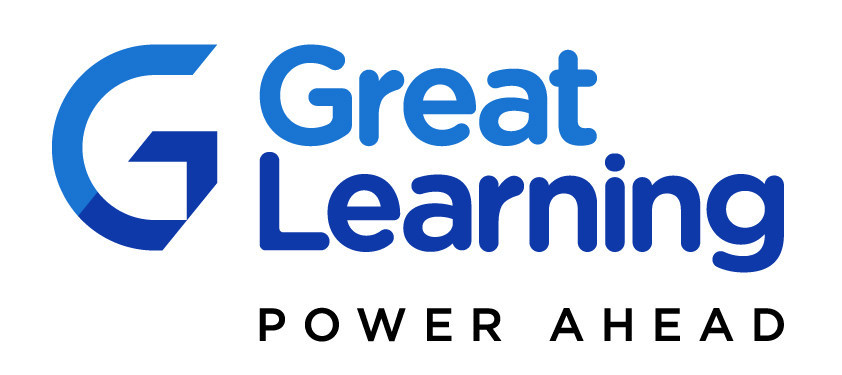

<h1><center><font size=10>Advanced Python - From Analytics to AI</center></font></h1>
<h1><center>Vector Databases - Setting up a Vector Database</center></h1>

## Problem Statement

### Business Context

In the world of online shopping, it's crucial for e-commerce platforms to help customers easily find and buy what they need. But with so many products available, it's a big challenge to make sure the right products are seen by the right people.

E-commerce sites face several key issues:

Lots of Products: There are so many different things to sell that it's hard to organize and categorize them all.
Search Problems: Traditional search tools don't always give the best results, especially if someone spells a word wrong or isn't very specific.
Keeping Customers Happy: It's important to make sure customers have a good experience and can find what they're looking for, so they keep coming back.

### Problem Definition
Big E-Commerce Company X (not x.com, X is an alias here) knows these challenges all too well. They have a huge range of products, from electronics to clothes to home items, and sorting them all out manually takes a lot of time. Plus, if they don't get it right, customers might struggle to find what they want.

As part of the Data Science team at Big E-Commerce Company X, the goal is to find a better way to help people discover products. By using clever techniques like embedding-based similarity search, the plan is to make searching for products easier and more accurate, so customers can find what they want quickly and easily.The perfect way to do this is by having a NLP based spelling correction system as first step and then using embedding similarity search as the second step. since we are limited by time in this session, we are going to step 2 directly.

Apart from product search, product recommendation can also be done using similarity search. We are going to do both search and product recommendation in this session.

The first step for both search and recommendation is converting the text(product description) into embeddings and storing it into a vector database. This process runs quickly with a GPU. After this step, we can implement the search and recommendation using a CPU itself. Hence, we are going to break this MLS into two notebooks. In the first one, we are going to setup the vectorDB using GPU and persist the vectorDB in Gdrive. In the second notebook, we are going to implement the search and recommendation on a CPU.

## Vectorising Products

Let's start with the setup...

### Setup

In [ ]:
!pip install -q chromadb==0.4.22 \
                langchain==0.1.9 \
                langchain-community==0.0.32 \
                sentence-transformers==2.3.1

In [ ]:
from scipy.spatial.distance import cosine
import pandas as pd

from google.colab import userdata
from google.colab import drive

from langchain_core.documents import Document
from langchain_community.embeddings.sentence_transformer import SentenceTransformerEmbeddings
from langchain_community.vectorstores import Chroma


#### Importing the Embedding Model

In [ ]:
embedding_model_name = 'thenlper/gte-large'

In [ ]:
embedding_model = SentenceTransformerEmbeddings(model_name=embedding_model_name)

## Importing Data

In [ ]:
products_data = pd.read_csv("products_data.csv")

In [ ]:
products_data.shape

We have 11.5k+ products and 14 columns in this dataset. Let's have a glance at the data.

In [ ]:
products_data.head()

We can see that product_description is the most relevant detail for us for this use-case. Additionally, we could add details from other columns like weight and price into the product description. This will create embeddings with more details about the product.

In [ ]:
products_data.product_description[52]

Let's drop any duplicates products that may be present in the dataset.

In [ ]:
products_data.drop_duplicates(subset = "uniq_id",inplace= True)

In [ ]:
products_data.shape

There were no duplicate products in the dataset. Good!

In [ ]:
products_data["product_description"] = products_data["product_description"] + " from the company " + products_data["brand"] + " at the price " + products_data["price"] + " with a discount of " + products_data["offers"]

In [ ]:
products_data.product_description[52]

That is a better description of the product.

Let's create documents from the product description. Let's also add a little meta-deta so that if we quickly wish to show the meta-data in search resutls or if we want to do a pre-filter, it will come in handy

In [ ]:
docs = [Document(page_content = doc, metadata = {"id":id, "price": price})for doc, id, price in zip(products_data['product_description'],products_data['uniq_id'],products_data['price'])
                 ]

# Indexing to Chroma

In [ ]:
products = Chroma.from_documents(
    docs,
    embedding_model,
    collection_name="product_embeddings",
    persist_directory='./products_db'
)

Let's do a test query!

In [ ]:
query = "rose scented perfume" # If there are no rose scented perfumes, it should suggest other flowery or fruity flavours before moving to men perfumes.

In [ ]:
docs = products.similarity_search(query, k=5)

In [ ]:
for i, doc in enumerate(docs):
    print(f"Retrieved chunk {i+1}: \n")
    print(doc.page_content.replace('\t', ' '))
    print('\n')

# Save Database State to Google Drive

Using a GPU to create an index is the most compute intensive portion of operating a vector database. While we have persisted the database to the local Colab instance in the previous section, this folder is lost once the notebook is disconnected. To avoid losing data, we can copy the database state from the notebook to Google Drive for later reuse.

Provide Gdrive access to colab

In [ ]:
drive.mount('/content/drive')

In [ ]:
!cp -r products_db /content/drive/MyDrive

The above code saves the database state to Google Drive (within My Drive).

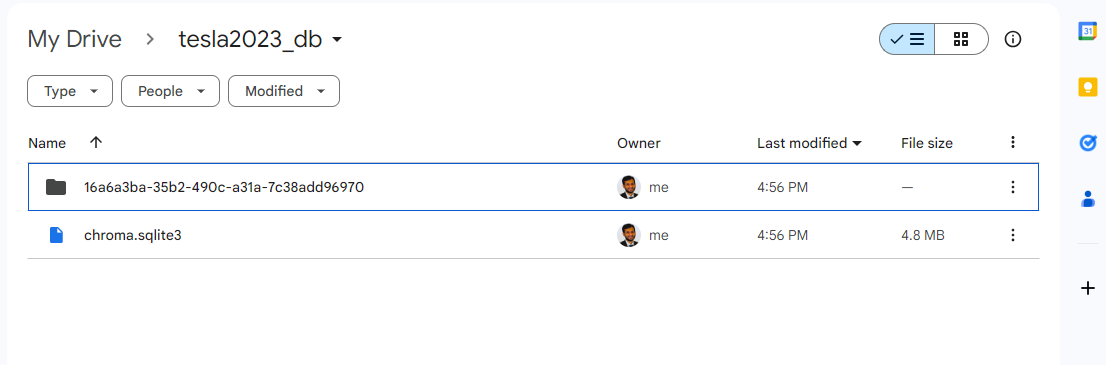

Let's check the persisted DB once before we move on to the next task.

In [ ]:
persisted_vectordb_location = '/content/drive/MyDrive/products_db'

In [ ]:
vectorstore_persisted = Chroma(
    collection_name="product_embeddings",
    persist_directory=persisted_vectordb_location,
    embedding_function=embedding_model
)

That was super quick! Let's do a quick check.

In [ ]:
docs = vectorstore_persisted.similarity_search(query, k=5)

In [ ]:
for i, doc in enumerate(docs):
    print(f"Retrieved chunk {i+1}: \n")
    print(doc.page_content.replace('\t', ' '))
    print('\n')

We can now run the similarity search as before, but the database is hosted and streamed from Google Drive.

We can now go ahead and switch to a Non-GPU isntance and perfrom the later stages of the project. Even in industry, similar strategy can be used where we use GPU instances to create vectorDB and persist in a safe location and later use CPU instances for everyday serach queries from the website.